# Initialization

Let us begin by loading Getfem and pyvista.

In [1]:
import getfem as gf
import pyvista as pv
import numpy as np

from pyvirtualdisplay import Display
import os
display = Display(visible=0, size=(1280, 1024))
display.start()

pv.set_plot_theme("document")

# Mesh generation

When you want to build mesh from empty situation, you can use "empty" command in Mesh object.

In [2]:
gf.Mesh?

Init signature: gf.Mesh(*args)
Docstring:     
GeFEM Mesh object

This object is able to store any element in any dimension even if you mix
elements with different dimensions.
Init docstring:
General constructor for Mesh objects

* ``M = Mesh('empty', int dim)``
  Create a new empty mesh.

* ``M = Mesh('cartesian', vec X[, vec Y[, vec Z,..]])``
  Build quickly a regular mesh of quadrangles, cubes, etc.

* ``M = Mesh('pyramidal', vec X[, vec Y[, vec Z,..]])``
  Build quickly a regular mesh of pyramids, etc.

* ``M = Mesh('cartesian Q1', vec X, vec Y[, vec Z,..])``
  Build quickly a regular mesh of quadrangles, cubes, etc. with
  Q1 elements.

* ``M = Mesh('triangles grid', vec X, vec Y)``
  Build quickly a regular mesh of triangles.
  
  This is a very limited and somehow deprecated function (See also
  ``Mesh('ptND')``, ``Mesh('regular simplices')`` and
  ``Mesh('cartesian')``).

* ``M = Mesh('regular simplices', vec X[, vec Y[, vec Z,...]]['degree', int k]['noised'])``
  Mesh a n-dime

In [3]:
mesh = gf.Mesh("empty", 3)

for x in range(10):
    for y in range(10):
        for z in [0, 10]:
            mesh.add_convex(
                gf.GeoTrans("GT_PRODUCT(GT_QK(1, 1), GT_QK(1, 1))"),
                [[x, x+1, x, x+1], [y, y, y+1, y+1], [z, z, z, z]],
            )

for x in range(10):
    for z in range(10):
        for y in [0, 10]:
            mesh.add_convex(
                gf.GeoTrans("GT_PRODUCT(GT_QK(1, 1), GT_QK(1, 1))"),
                [[x, x+1, x, x+1], [y, y, y, y], [z, z, z+1, z+1]],
            )

for y in range(10):
    for z in range(10):
        for x in [0, 10]:
            mesh.add_convex(
                gf.GeoTrans("GT_PRODUCT(GT_QK(1, 1), GT_QK(1, 1))"),
                [[x, x, x, x], [y, y+1, y, y+1], [z, z, z+1, z+1]],
           )

mesh.translate([-5.0, -5.0, -5.0])
mesh.export_to_vtk("m1.vtk")

In [4]:
pts = mesh.pts()
radius = np.sqrt(pts[0]**2 + pts[1]**2 + pts[2]**2)
mesh.set_pts(pts*(100.0/radius))
mesh.export_to_vtk("m2.vtk")

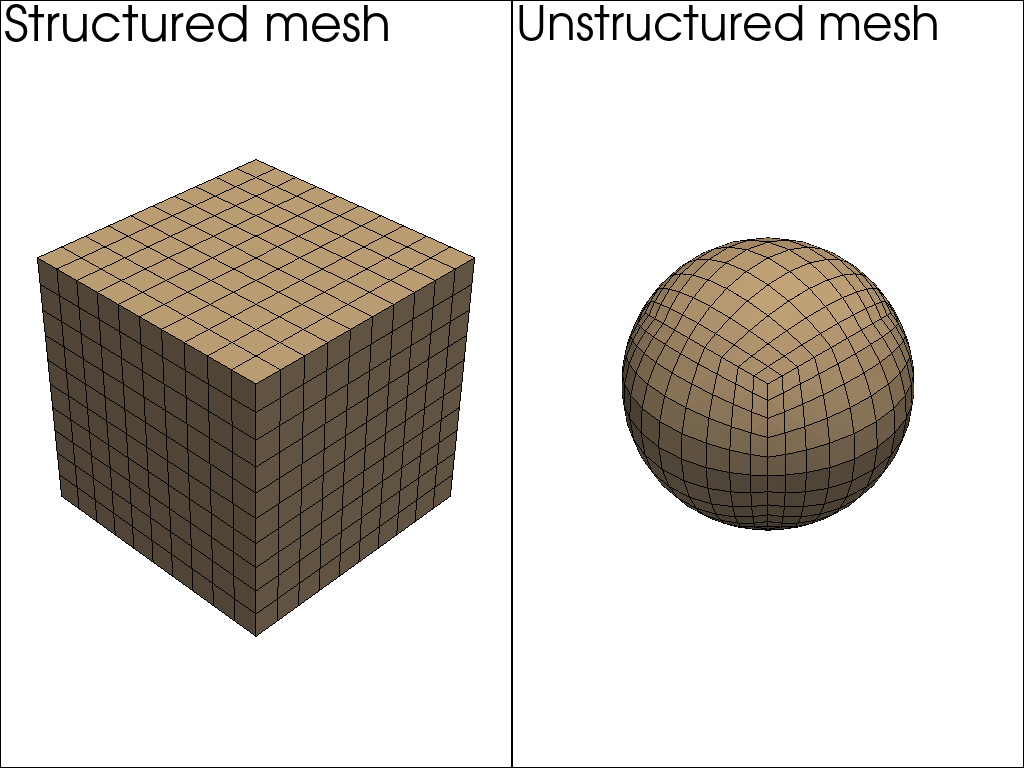

[(568.669124079371, 568.669124079371, 568.669124079371),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 1.0)]

In [5]:
p = pv.Plotter(shape=(1, 2))
p.subplot(0, 0)
mesh1 = pv.read("m1.vtk")
p.add_text("Structured mesh", font_size=24)
p.add_mesh(mesh1, show_edges = True)
p.subplot(0, 1)
mesh2 = pv.read("m2.vtk")
p.add_text("Unstructured mesh", font_size=24)
p.add_mesh(mesh2, show_edges = True)
p.show()

In [6]:
gf.MeshFem?

Init signature: gf.MeshFem(*args)
Docstring:     
GeFEM MeshFem object

This object represents a finite element method defined on a whole mesh.
Init docstring:
General constructor for MeshFem objects

* ``MF = MeshFem(Mesh m[, int Qdim1=1[, int Qdim2=1, ...]])``
  Build a new MeshFem object.
  
  The `Qdim` parameters specifies the dimension of the field represented
  by the finite element method. Qdim1 = 1 for a scalar field,
  Qdim1 = n for a vector field off size n, Qdim1=m, Qdim2=n for
  a matrix field of size mxn ...
  Returns the handle of the created object. 

* ``MF = MeshFem('load', string fname[, Mesh m])``
  Load a MeshFem from a file.
  
  If the mesh `m` is not supplied (this kind of file does not store the
  mesh), then it is read from the file `fname` and its descriptor is
  returned as the second output argument.

* ``MF = MeshFem('from string', string s[, Mesh m])``
  Create a MeshFem object from its string description.
  
  See also ``MeshFem.char()``

* ``MF = MeshFe

In [7]:
mfu = gf.MeshFem(mesh, 3)
mfd = gf.MeshFem(mesh, 1)
mfu.set_classical_fem(1)
mfd.set_classical_fem(1)
mim = gf.MeshIm(mesh, 2)

In [8]:
model = gf.Model("real")
model.add_fem_variable("u", mfd)
model.add_initialized_data("E", 1.0)
model.add_initialized_data("Nu", 0.3)
model.add_Kirchhoff_Love_plate_brick(mim, "u", "E", "Nu")
model.assembly()
K = model.tangent_matrix()
del model

In [9]:
model = gf.Model("real")
model.add_fem_variable("u", mfd)
model.add_initialized_data("rho", 1.0/(10^6))
model.add_mass_brick(mim, "u", "rho")
model.assembly()
M = model.tangent_matrix()
del model

In [10]:
K.save?

Signature: K.save(format, filename)
Docstring:
Export the sparse matrix.

the format of the file may be 'hb' for Harwell-Boeing, or 'mm'
for Matrix-Market.
File:      /usr/lib/python3/dist-packages/getfem/getfem.py
Type:      method


In [11]:
K.save("mm", "K.mtx")
M.save("mm", "M.mtx")

In [12]:
linalg.eig?

Object `linalg.eig` not found.


In [13]:
import scipy
from scipy import io
from scipy import linalg

SM = io.mmread("K.mtx")
MM = io.mmread("M.mtx")
w, vr = linalg.eig(SM.todense(), MM.todense())
omega = np.sqrt(w.real)

<ipython-input-13-18e62582bc6f>:8: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(w.real)


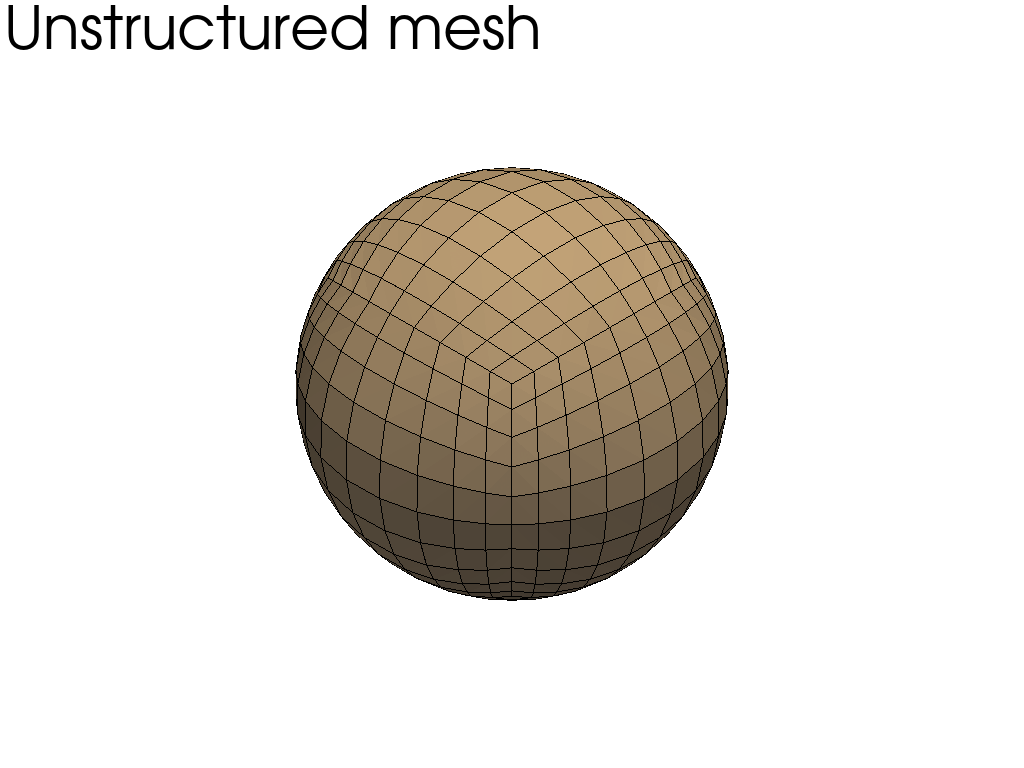

[(386.37033051562736, 386.37033051562736, 386.37033051562736),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 1.0)]

In [14]:
p = pv.Plotter(shape=(1, 1))
p.subplot(0, 0)
mesh2 = pv.read("m2.vtk")
p.add_text("Unstructured mesh", font_size=24)
p.add_mesh(mesh2, show_edges = True)
p.show()

In [15]:
mesh2 = mesh
pts = mesh2.pts()
radius = np.sqrt(pts[0]**2 + pts[1]**2 + pts[2]**2)
mesh2.set_pts(pts*(np.abs(vr[:, 10])/np.max(np.abs(vr[:, 0]))/radius))
mesh2.export_to_vtk("m3.vtk")

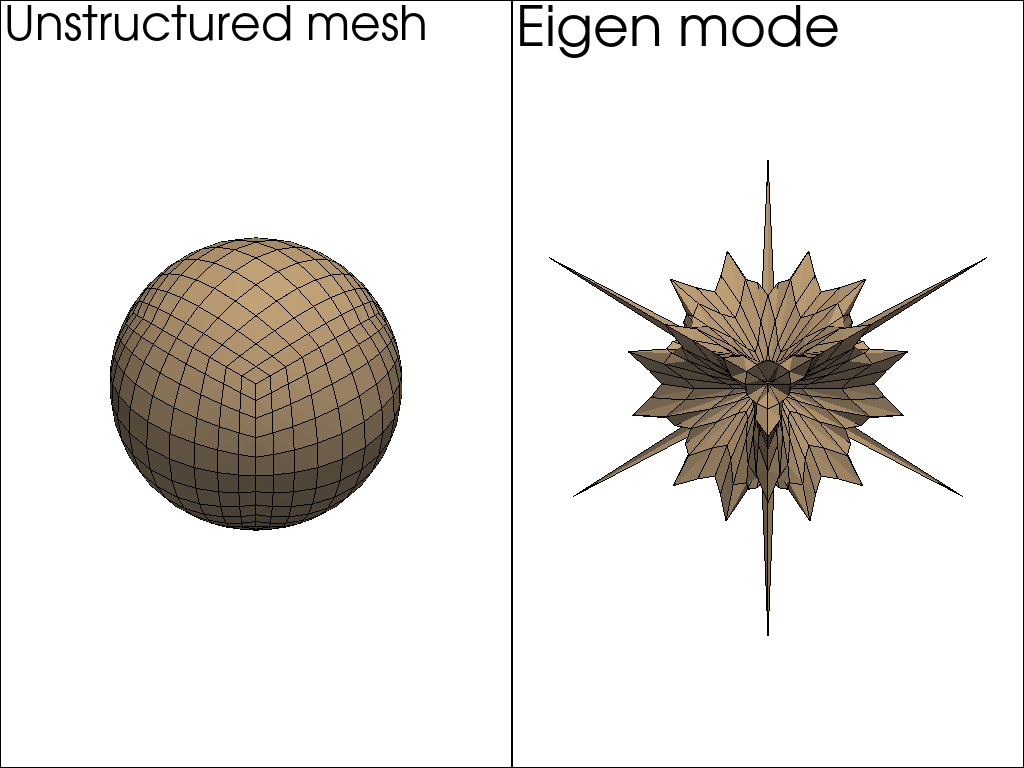

[(2.32100872257932, 2.32100872257932, 2.32100872257932),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 1.0)]

In [16]:
p = pv.Plotter(shape=(1, 2))
p.subplot(0, 0)
mesh2 = pv.read("m2.vtk")
p.add_text("Unstructured mesh", font_size=24)
p.add_mesh(mesh2, show_edges = True)
p.subplot(0, 1)
mesh2 = pv.read("m3.vtk")
p.add_text("Eigen mode", font_size=24)
p.add_mesh(mesh2, show_edges = True)
p.show()